# Auto Encoder - Image Colorization

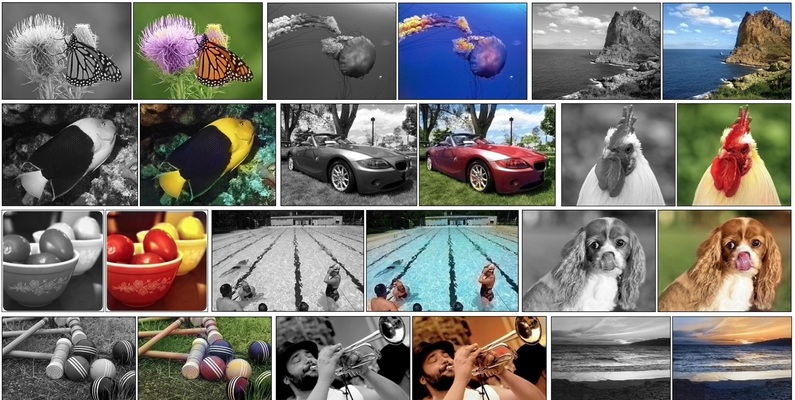

Dataset: [Kaggle](https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset)

Github: https://github.com/aayush9753/ColorIt

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

 96% 185M/192M [00:05<00:00, 23.9MB/s]
100% 192M/192M [00:05<00:00, 38.4MB/s]


In [4]:
!unzip -qq landscape-image-colorization.zip

In [ ]:
# Feature (input awal) --> gray
# Target (output akhir) --> color

# Data training --> split 20% validation
# Feauture --> train_gray
# Target --> train_color

In [5]:
# Pipeline Dataset
# 1. Buka file gambar, sebagai matrix 3D
# 2. Resize jadi ukuran tertentu
# 3. Normalisasi dari 0-255 jadi 0-1
# 4. Tentuin batch

import tensorflow as tf
from sklearn.model_selection import train_test_split
from glob import glob

train_black_paths = glob('landscape Images/gray/*jpg') # feature x
train_color_paths = glob('landscape Images/color/*jpg') # target y

# split training & validation
x_train, x_val, y_train, y_val = train_test_split(train_black_paths, train_color_paths, test_size=0.2, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))


TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
SHUFFLE_BUFFER = 128
PREFETCH = tf.data.AUTOTUNE


@tf.function
def parse_function(x_path, y_path):

  x_file = tf.io.read_file(x_path)
  y_file = tf.io.read_file(y_path)

  x_image = tf.image.decode_jpeg(x_file, channels=3) # matrix 3D
  x_image = tf.image.convert_image_dtype(x_image, dtype=tf.float32) # normalisasi
  x_image = tf.image.resize(x_image, TARGET_SIZE) # resize

  y_image = tf.image.decode_jpeg(y_file, channels=3)
  y_image = tf.image.convert_image_dtype(y_image, dtype=tf.float32)
  y_image = tf.image.resize(y_image, TARGET_SIZE)
  
  return x_image, y_image

#untuk membuat pipeline input train dan validasi dataset tensorflow yg efisien
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_dataset = train_dataset.map(parse_function).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(PREFETCH)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(PREFETCH)

5703
1426
5703
1426


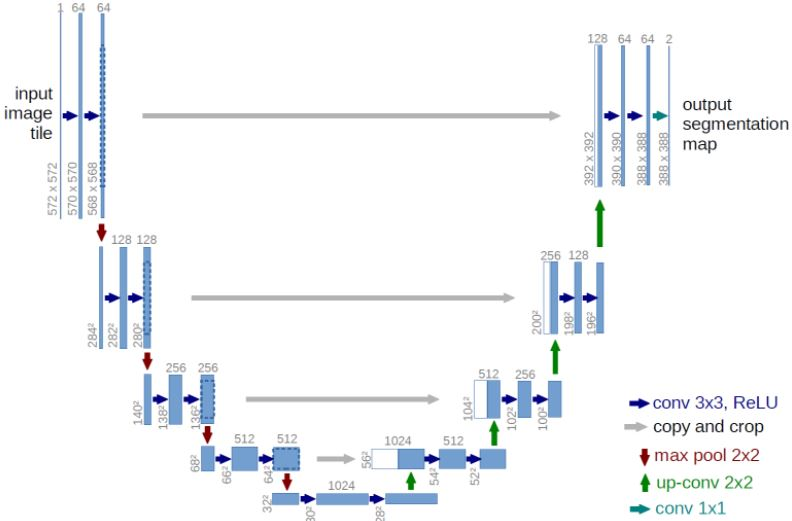

In [6]:
from tensorflow.keras import layers, models, optimizers, backend
from keras.utils.vis_utils import plot_model

backend.clear_session()

# U-NET

inputs = layers.Input(shape=(*TARGET_SIZE, 3))
relu = layers.Activation('relu')(inputs)
bn = layers.BatchNormalization()(relu)

x1 = layers.Conv2D(32, 3, padding='same')(bn)
relu = layers.Activation('relu')(x1)
bn = layers.BatchNormalization()(relu)

x1 = layers.Conv2D(32, 3, padding='same')(bn)
relu = layers.Activation('relu')(x1)
bn = layers.BatchNormalization()(relu)

p1 = layers.MaxPool2D(2, 2)(bn)
relu = layers.Activation('relu')(p1)
bn = layers.BatchNormalization()(relu)

x2 = layers.Conv2D(64, 3, padding='same')(bn)
relu = layers.Activation('relu')(x2)
bn = layers.BatchNormalization()(relu)

x2 = layers.Conv2D(64, 3, padding='same')(bn)
relu = layers.Activation('relu')(x2)
bn = layers.BatchNormalization()(relu)

p2 = layers.MaxPool2D(2, 2)(bn)
relu = layers.Activation('relu')(p2)
bn = layers.BatchNormalization()(relu)

x3 = layers.Conv2D(128, 3, padding='same')(bn)
relu = layers.Activation('relu')(x3)
bn = layers.BatchNormalization()(relu)

x3 = layers.Conv2D(128, 3, padding='same')(bn)
relu = layers.Activation('relu')(x3)
bn = layers.BatchNormalization()(relu)

p3 = layers.MaxPool2D(2, 2)(bn)
relu = layers.Activation('relu')(p3)
bn = layers.BatchNormalization()(relu)

x4 = layers.Conv2D(256, 3, padding='same')(bn)
relu = layers.Activation('relu')(x4)
bn = layers.BatchNormalization()(relu)

x4 = layers.Conv2D(256, 3, padding='same')(bn)
relu = layers.Activation('relu')(x4)
bn = layers.BatchNormalization()(relu)

p4 = layers.MaxPool2D(2, 2)(bn)
relu = layers.Activation('relu')(p4)
bn = layers.BatchNormalization()(relu)

b = layers.Conv2D(512, 3, padding='same')(bn)
relu = layers.Activation('relu')(p4)
bn = layers.BatchNormalization()(relu)

u1 = layers.UpSampling2D(size=(2, 2))(bn)
relu = layers.Activation('relu')(u1)
bn = layers.BatchNormalization()(relu)

c1 = layers.Concatenate()([x4, u1])
relu = layers.Activation('relu')(c1)
bn = layers.BatchNormalization()(relu)

y1 = layers.Conv2D(256, 3, padding='same')(bn)
relu = layers.Activation('relu')(y1)
bn = layers.BatchNormalization()(relu)

u2 = layers.UpSampling2D(size=(2, 2))(bn)
relu = layers.Activation('relu')(u2)
bn = layers.BatchNormalization()(relu)

c2 = layers.Concatenate()([x3, u2])
relu = layers.Activation('relu')(c2)
bn = layers.BatchNormalization()(relu)

y2 = layers.Conv2D(128, 3, padding='same')(bn)
relu = layers.Activation('relu')(y2)
bn = layers.BatchNormalization()(relu)

u3 = layers.UpSampling2D(size=(2, 2))(bn)
relu = layers.Activation('relu')(u3)
bn = layers.BatchNormalization()(relu)

c3 = layers.Concatenate()([x2, u3])
relu = layers.Activation('relu')(c3)
bn = layers.BatchNormalization()(relu)

y3 = layers.Conv2D(64, 3, padding='same')(bn)
relu = layers.Activation('relu')(y3)
bn = layers.BatchNormalization()(relu)

u4 = layers.UpSampling2D(size=(2, 2))(bn)
relu = layers.Activation('relu')(u4)
bn = layers.BatchNormalization()(relu)

c4 = layers.Concatenate()([x1, u4])
relu = layers.Activation('relu')(c4)
bn = layers.BatchNormalization()(relu)

y4 = layers.Conv2D(32, 3, padding='same')(bn)
relu = layers.Activation('relu')(y4)
bn = layers.BatchNormalization()(relu)

y4 = layers.Conv2D(32, 3, padding='same')(bn)
relu = layers.Activation('relu')(y4)

outputs = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(y4)

model = models.Model(inputs, outputs)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.summary()

def psnr(pred, gt):
  return tf.image.psnr(pred, gt, max_val=1.0)

def ssim(pred, gt):
  return tf.image.ssim(pred, gt, max_val=1.0)

model.compile(loss='mse', optimizer=optimizers.Adamax(learning_rate=1e-3), metrics=[psnr, ssim])

model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    epochs=20
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 activation (Activation)        (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 3)  12         ['activation[0][0]']             
 alization)                                                                                       
                                                                                              

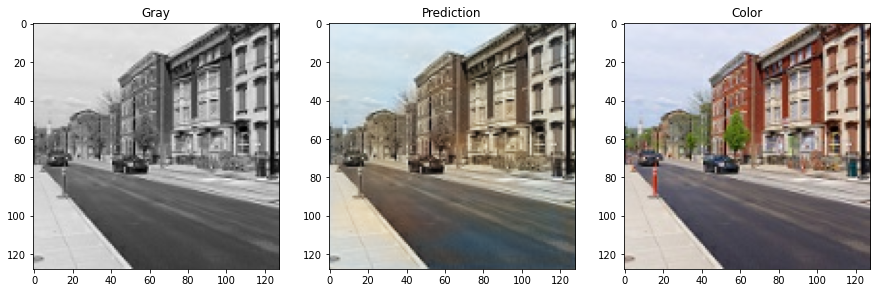

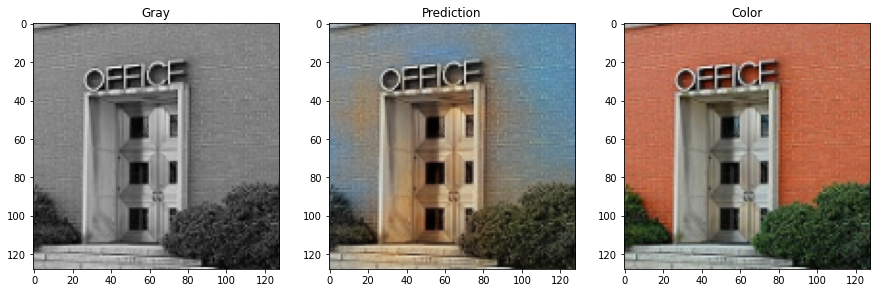

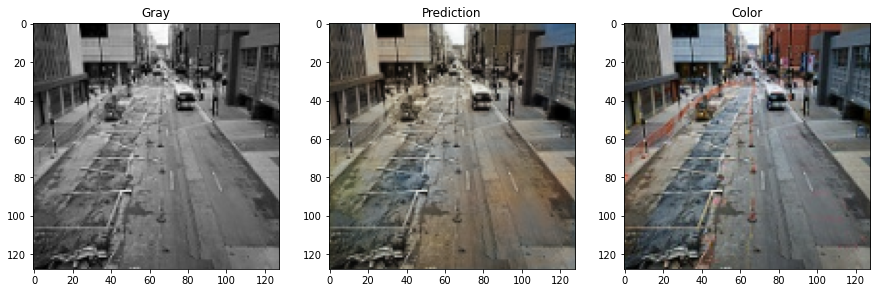

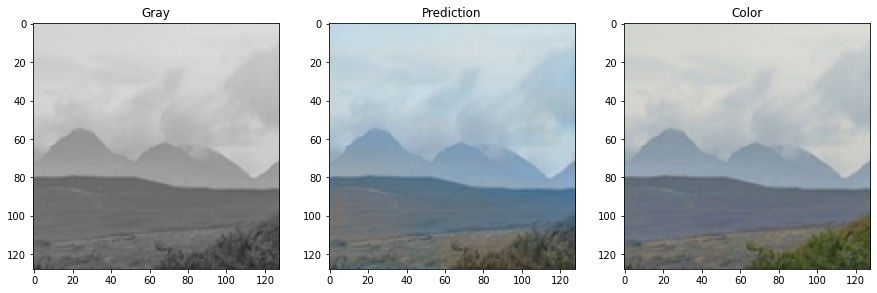

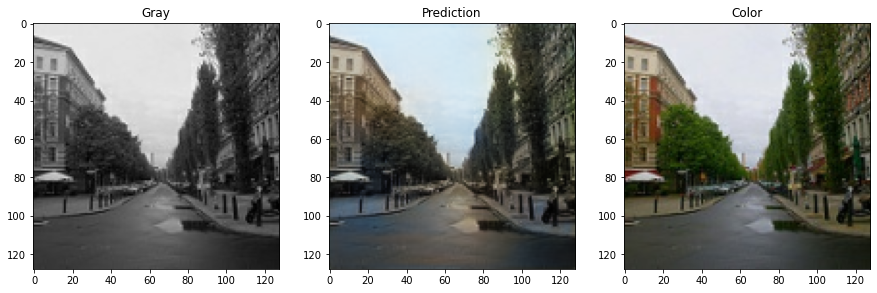

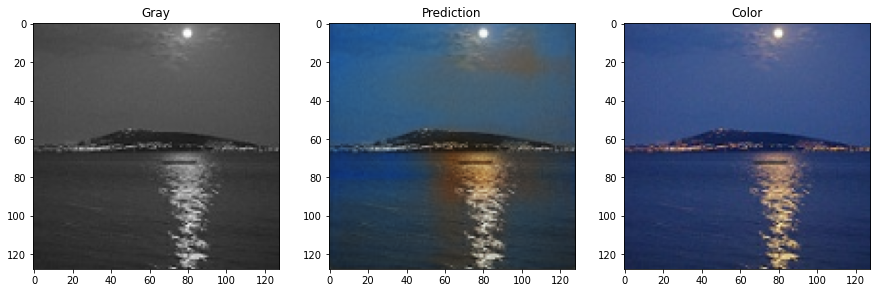

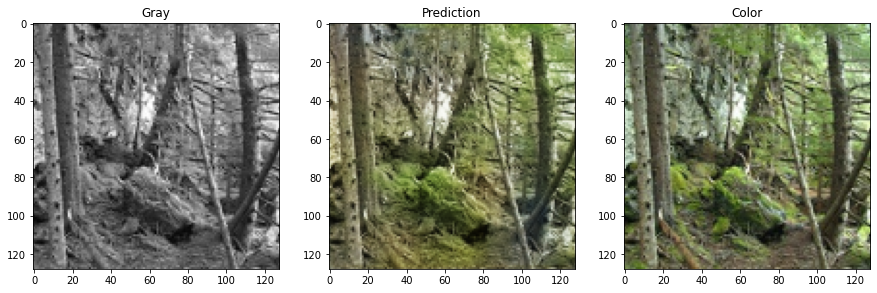

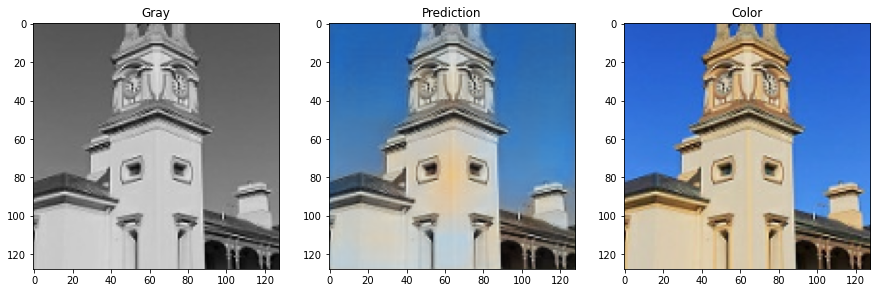

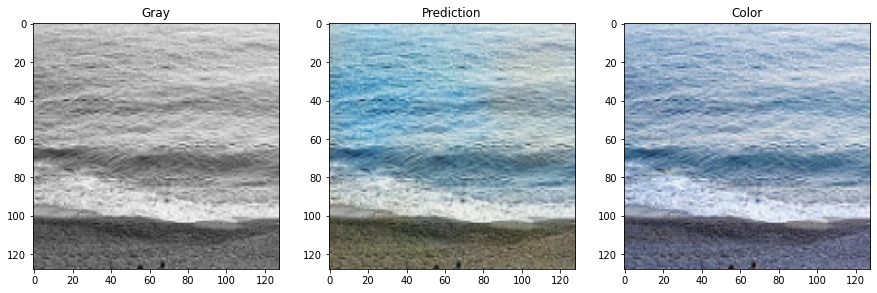

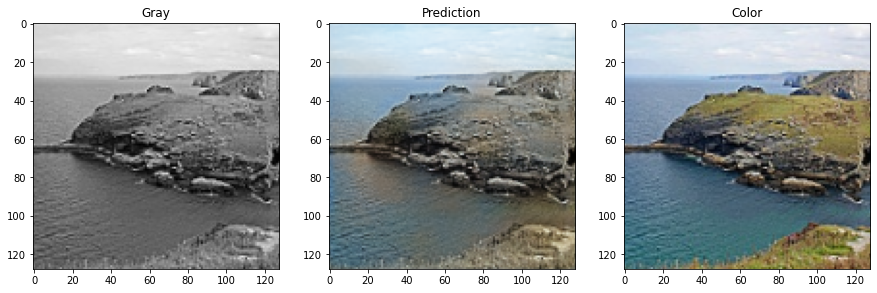

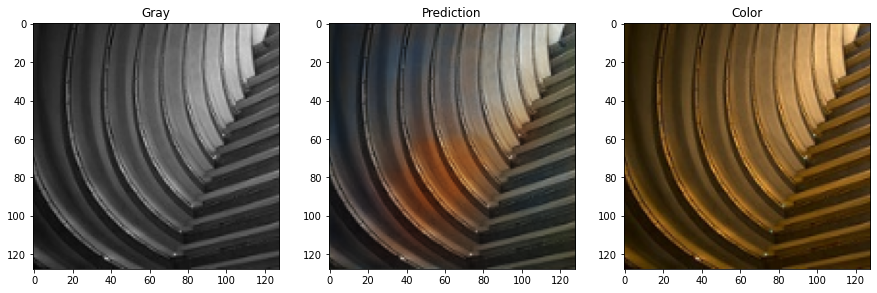

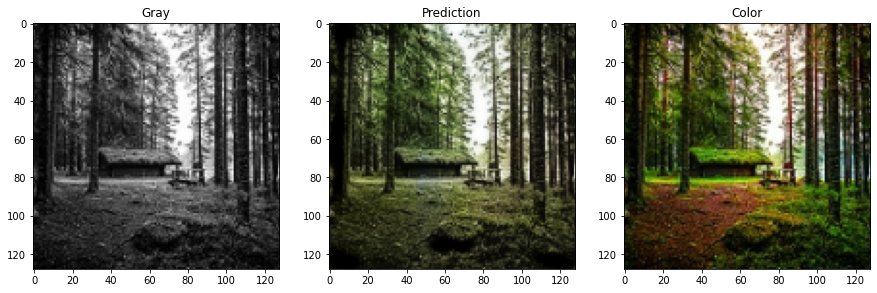

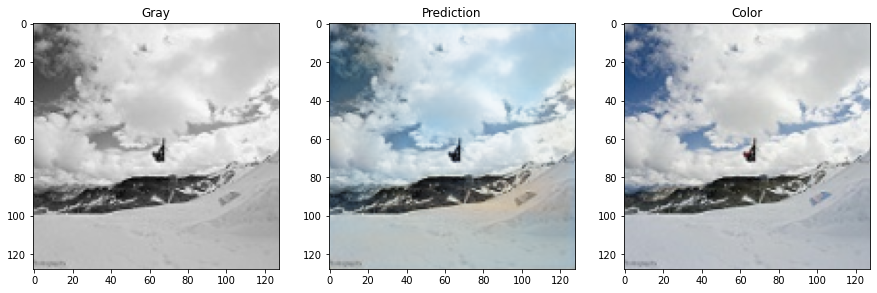

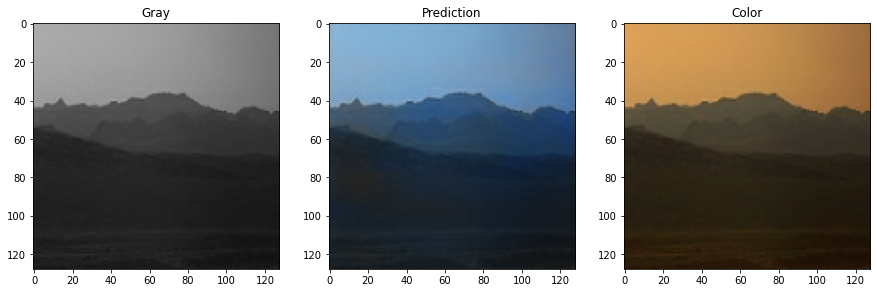

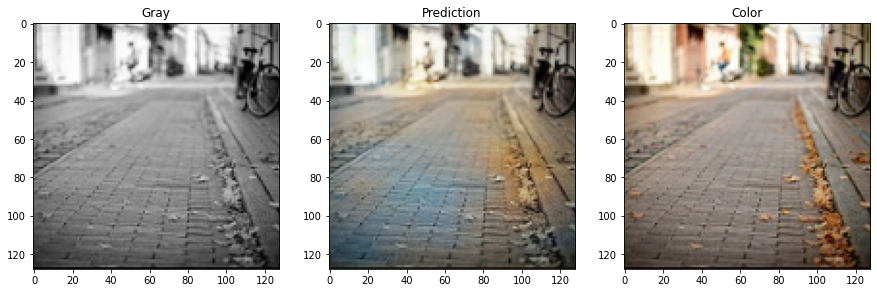

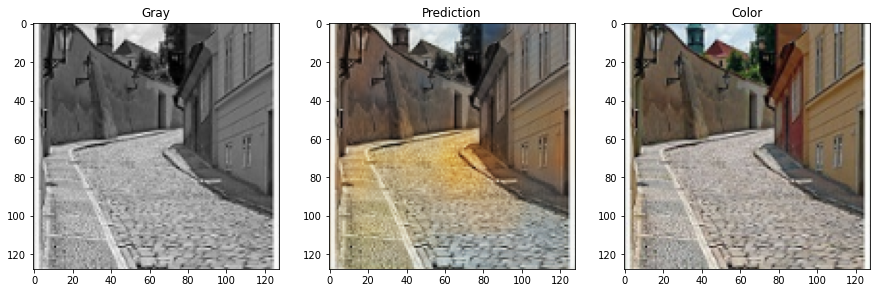

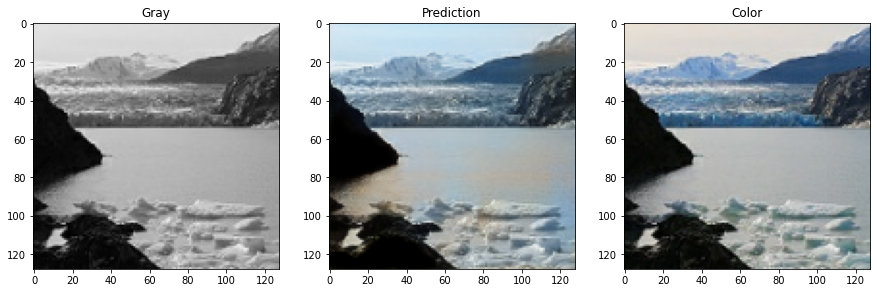

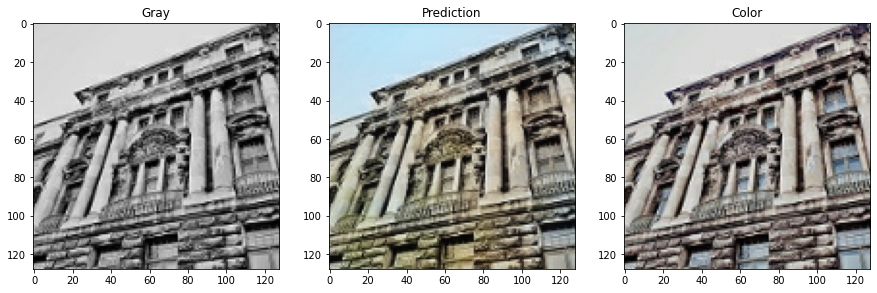

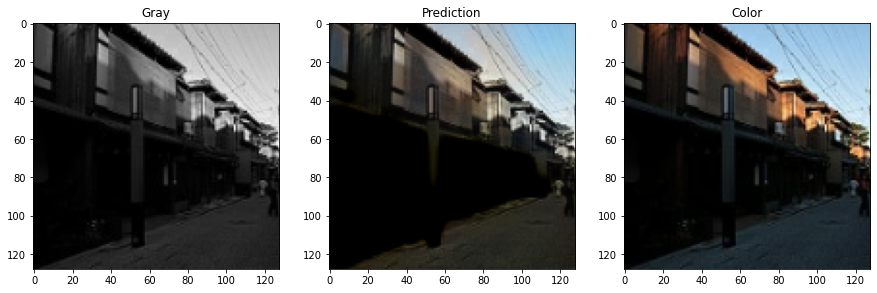

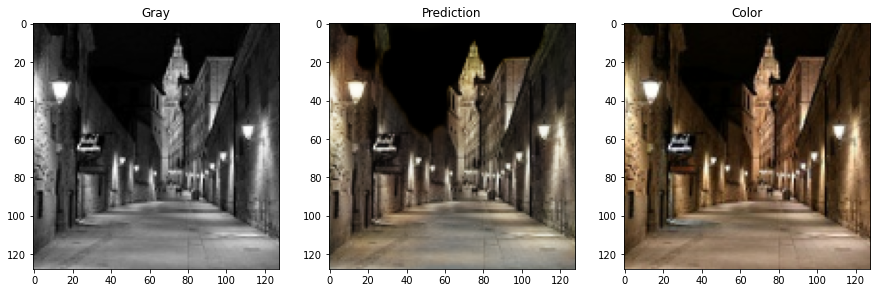

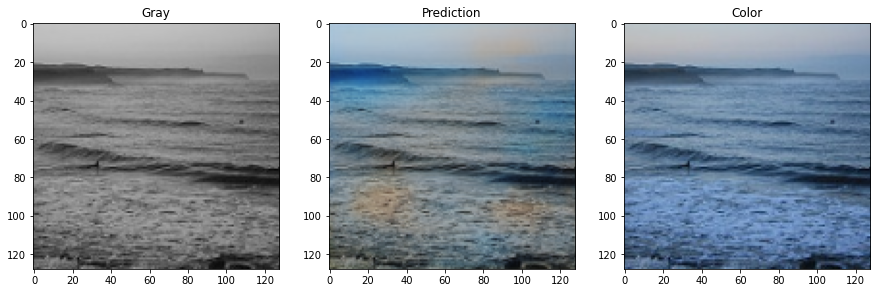

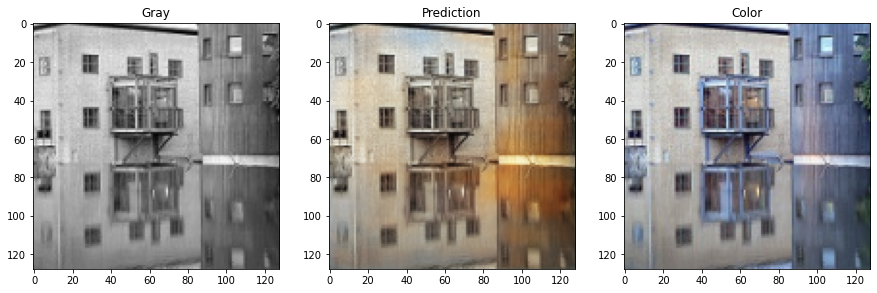

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for black, color in zip(x_val[:40], y_val[:40]):
  x, y = parse_function(black, color)
  pred = model(np.expand_dims(x, axis=0))
  y_hat = np.squeeze(pred, axis=0)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title('Gray')
  plt.imshow(x)
  plt.subplot(1, 3, 2)
  plt.title('Prediction')
  plt.imshow(y_hat)
  plt.subplot(1, 3, 3)
  plt.title('Color')
  plt.imshow(y)
  plt.show()